In [1]:
import numpy as np
from scipy import sparse
from math import sqrt
import matplotlib.pyplot as plt
import networkx as nx
import random
import gudhi

In [2]:
class geometric_network():
    def __init__(self, network_type, size, **kwargs):
        ####################################
        ##### Geometric Network Object #####
        ####################################
        
        ### input -- network_type:
        ##                      2D_lattice: creates 2d lattice of given tiling-can be triangular, square, hexagonal
        #                                   --Additional Arguments--
        #                                     tiling = 3,4,6
        #                                     periodic = bool (connects the edge of the grid to the opposite edge)
        ##                      ring_lattice: creates a ring graph with each node degree 2
        #                                    --Additional Arguments--
        #                                     banded = bool
        #                                     band_length = gonna connect this many closest neigbors (skipping the 
        #                                                   adjacent nodes from both sides because they are already 
        #                                                   connected) from both sides to every node
        #                                     
        #                                     
        ### input -- size: network size, if 2D_lattice, then there will be size^2 many nodes.
        
        ### attribute -- geometric_network.N
        ### attribute -- geometric_network.M
        ### attribute -- geometric_network.graph
        ### attribute -- geometric_network.pos
        ### attribute -- geometric_network.A
        ### attribute -- geometric_network.text 
        
        ### function -- geometric_network.display(n_size, labels = Bool): take a sneakpeak on the networkx object
        ### function -- geometric_network.add_noise_to_geometric(noise_type, d2): add two types of noise
        #                                   either 'ER_like' or 'k_regular' of degree d2
        ### function -- geometric_network.run_excitation(Trials, p, T, seed, threshold): run 
        #                                   the excitation according to these parameters
        
        ### function -- geometric_network.spy_first_activation(first_activation_times): visualize the first
        #                                   activation, input of the functin is the 2nd output of run_excitation
        
        if network_type == '2D_lattice': 
            tiling = kwargs['tiling']
            per = kwargs['periodic']
            if tiling == 3: 
                self.graph = nx.triangular_lattice_graph(size, size, periodic = per, with_positions = True)
                self.pos = nx.get_node_attributes(self.graph,'pos')
                self.M = len(self.graph.edges())
                self.N = len(self.graph.nodes())
                

            elif tiling == 4: 
                self.graph = nx.grid_2d_graph(size, size, periodic = per)
                self.pos = dict( (n, n) for n in self.graph.nodes() )
                self.labels = dict( ((i, j), i * size + j) for i, j in self.graph.nodes() )
                self.M = len(self.graph.edges())
                self.N = len(self.graph.nodes())
                
            elif tiling == 6: 
                self.graph = nx.hexagonal_lattice_graph(size, size, periodic = per, with_positions = True)
                self.pos = nx.get_node_attributes(self.graph,'pos')
                self.M = len(self.graph.edges())
                self.N = len(self.graph.nodes())
            
            
        elif network_type == 'ring_lattice':# TODO: banding for every node
            self.graph = nx.cycle_graph(size)
            theta = (2*np.pi)/size
            self.pos = dict((i,(np.sin(theta*i),np.cos(theta*i))) for i in range(size))
            self.M = len(self.graph.edges())
            self.N = len(self.graph.nodes())
            self.text = 'Ring Lattice'
            if kwargs['banded']:
                if kwargs['band_length'] >= int(self.N/2)-1: raise ValueError('Band length cannot exceed the half of the size of the network')
                if kwargs['band_length'] <2: raise ValueError('Band length should be a positive integer greater 1 since the closest neighbors are already connected')
                for u in range(self.N):
                    for i in range(2,kwargs['band_length']+1):# ranges from 2 to k+2 to avoid the closest node and start
                        ## banding from the second closest node
                        if u + i >= self.N: v = u + i - self.N
                        else: v = u + i
                        self.graph.add_edge(u, v)
                        if u - i < 0: v = self.N + u - i
                        else: v = u - i
                        self.graph.add_edge(u, v)
                self.text = self.text + ' w/ bandlength %d'%kwargs['band_length']
            else:self.text = self.text + ' w/ bandlength 0'
                        
        else: raise ValueError('network type can be a lattice or a ring')
            
        self.A = nx.adjacency_matrix(self.graph)## use .toarray() or .todense() attributes to call the sparse matrix
              
    def display(self, n_size = 15, labels = True):
        
        try: return(nx.draw(self.graph, pos = self.pos, node_size = n_size, with_labels = labels, font_weight = 'bold'))
        
        except: return(nx.draw(self.graph, with_labels = labels, font_weight = 'bold'))
        
    def add_noise_to_geometric(self, noise_type, d2):
        
        # this function adds nongeometric edges to the network that are long range. Depending on the 'noise_type'
        # the way we add these long range edges differ. If noise_type = ER_like, then there will be d2 many
        # non geometric edges ON AVARAGE for every node. When the noise_type = k_regular, every node will 
        # have exactly d2 many long range edges
        
        
        if noise_type == 'ER_like':   
            
            M = int(self.N * d2)
        
            if M%2 == 1: raise ValueError('Try providing an even non-geometric degree')
                
            edges_built = 0
            
            while edges_built <= M/2:
                
                nodes_to_connect = [random.randint(0,self.N-1) for i in range(2)]
                
                if nodes_to_connect[0] == nodes_to_connect[1]: #no self-loops
                    edges_built = edges_built
                elif self.A.toarray()[nodes_to_connect[0]][nodes_to_connect[1]] == 1 or self.A.toarray()[nodes_to_connect[1]][nodes_to_connect[0]] == 1: # no existing loops
                    edges_built = edges_built
                else: 
                    self.graph.add_edge(nodes_to_connect[0],nodes_to_connect[1])
                    edges_built = edges_built + 1
            self.text = self.text + ' & ER-like noise w/ degree %d'%d2

                    
        elif noise_type == 'k_regular':
            
            self.text = self.text + ' & k-regular noise w/ degree %d'%d2
            
            M = int(self.N * d2)
        
            if M%2 == 1: raise ValueError('Try providing an even non-geometric degree')
            
            flag_2 = True
            
            while flag_2:
                flag_2 = False
                #build stubs
                stubs = np.zeros(M)
                for i in range(self.N):
                    index = (i*d2) + np.arange(d2)
                    stubs[index[0]:index[-1]+1] = (i) * np.ones(d2)
                    
                #build undirected link list
                link_list = np.zeros((int(M/2),2))
                for m in range(int(M/2)):
                    flag_1 = True # turn on flag to enter while loop
                    count = 0
                    while flag_1:
                        flag_1 = False #turn off flag to exit while loop
                        rand = [random.randint(0,len(stubs)-1) for i in range(2)]
                        
                        node_A = int(stubs[rand[0]])
                        node_B = int(stubs[rand[1]])
                                                
                        if node_A == node_B: flag_1 = True
                        
                        for n in range(m):
                            if link_list[n,0] == node_A and link_list[n,1] == node_B:
                                flag_1 = True
                            if link_list[n,0] == node_B and link_list[n,1] == node_A:
                                flag_1 = True
                            if self.A.toarray()[node_A][node_B] == 1 or self.A.toarray()[node_B][node_A] == 1:
                                flag_1 = True
                                
                        count = count +1
                        
                        if count > M: flag_2 = True ; break
                            
                    #make link       
                    link_list[m,0] = node_A
                    link_list[m,1] = node_B
                    
                    #remove stubs from list
                    stubs = np.delete(stubs,[rand[0],rand[1]])
            
            #build network
            for m in range(int(M/2)):
                self.graph.add_edge(link_list[m,0],link_list[m,1])
            
        else: raise InputError('Noise type can only be ER_like or k_regular')
        self.A = nx.adjacency_matrix(self.graph)
    
    def excitation(self, p, T, seed, threshold, ax = None, spy = False):
        
        n = self.N
        x_1 = sparse.lil_matrix(((n,T+1)), dtype = bool)
        activation_times = np.ones(n, dtype = int)*T
        excited_nodes = self.A[seed].nonzero()[1]
        deg = len(excited_nodes)
        size_of_contagion = np.zeros(T)
        
        ps = np.array([random.uniform(0,1) for i in range(deg)])
        pss = np.array([1-p for i in range(deg)])
        
        vals = ps > pss
        
        for i in range(deg): x_1[excited_nodes[i],0] = vals[i]
            
        t = 0
        all_nodes = set([k for k in range(n)])
        size_of_contagion[t] = len(excited_nodes)
        
        while t<T and len(excited_nodes)>0 and np.any(activation_times==T):
            x_old = x_1.toarray()[:,t]
            excited_nodes = np.nonzero(x_old)[0]         
            activation_times[excited_nodes] = np.minimum(activation_times[excited_nodes],np.array([t]*len(excited_nodes)))
            activation_times = activation_times.astype(np.int32)
            t+=1
            for j in list(all_nodes-set(excited_nodes)): 
                ids = np.nonzero(self.A[j])[1]
                rands = [random.uniform(0,1) for i in range(len(ids))]
                
                valid_neighbor_activations = []

                for y,e in enumerate(ids):
                    if x_old[e]*rands[y] > 1-p:
                        valid_neighbor_activations.append(x_old[e]*rands[y])
                    
                x_1[j,t] = bool(np.sum(valid_neighbor_activations)/len(ids) >= threshold)
            
            size_of_contagion[t] = len(excited_nodes)
            

      
        if spy: ax.imshow(x_1.todense())
        
        if np.any(activation_times == T): 
            activation_retry, size_of_contagion = self.excitation(p, T, seed, threshold, ax = ax, spy = spy)
            return(activation_retry, size_of_contagion)
            
        else: return(activation_times, size_of_contagion)
    
    
    def run_excitation(self, Trials, p, T, seed, threshold, ax = None):
        
        n = self.N
        
        first_excitation_times = np.zeros((n,Trials))
        size_of_contagion = np.zeros((T,Trials))
        
        if ax is not None: 
            for i in range(Trials):
    
                first_exct, contagion_size = self.excitation(p = p, T = T, seed = seed, threshold = threshold, ax = ax[i], spy = True)
                first_excitation_times[:,i] = first_exct
                size_of_contagion[:,i] = contagion_size
                ax[i].set_title('Trial %d for %s'%(i+1, self.text), fontsize = 25)
                ax[i].set_xlabel('Time', fontsize = 35)
                ax[i].set_ylabel('Node ID',fontsize = 35)
                ax[i].set_xticks([5*t for t in range(int(T/5)+1)])
                ax[i].set_yticks([10*t for t in range(int(n/10))])
                ax[i].tick_params('both', which = 'major', labelsize = 15)
            plt.tight_layout()
            
        else:
            for i in range(Trials):
    
                first_exct, contagion_size = self.excitation(p = p, T = T, seed = seed, threshold = threshold)
                first_excitation_times[:,i] = first_exct
                size_of_contagion[:,i] = contagion_size
            
        return(first_excitation_times, size_of_contagion)
    

    def spy_first_activation(self, first_activation_times):
        
        fig,ax = plt.subplots(1,1,figsize = (10,8))
        
        pos = ax.imshow(first_activation_times, interpolation = 'nearest', aspect = 'auto', cmap = 'viridis',extent = [0.5,Trials+0.5,0,n])
        ax.set_title('First Activation Times for %s'%self.text, fontsize = 20)
        ax.set_xlabel('Trials', fontsize = 15)
        ax.set_ylabel('Node ID', fontsize = 15)
        ax.set_xticks([i for i in range(1,Trials+1)])
        
        fig.colorbar(pos, ax = ax)
        
    def average_over_trials(self, first_activation_times):return(np.mean(first_activation_times, axis = 1))
    
    def make_distance_matrix(self, p, T, threshold, Trials, spy_distance = False):
        n = self.N
        D = np.zeros((n,n))
        Q = np.zeros((n,T))
        
        for i in range(n):
            fat, qs = self.run_excitation(Trials, p, T, i, threshold)
            D[i], Q[i] = self.average_over_trials(fat), self.average_over_trials(qs)
        
        if spy_distance: 
            fig,ax = plt.subplots(1,1, figsize = (15*int(n/20),10*int(n/20)))
            pos = ax.imshow(D, origin = 'lower', interpolation = 'nearest', aspect = 'auto', cmap = 'viridis', extent = [-0.5,n-0.5,-0.5,n-0.5])
            ax.set_title('Distance Matrix for %s'%self.text, fontsize = 20)
            ax.set_ylabel('Excitation starting from node i', fontsize = 15)
            ax.set_xlabel('First time node j gets activated', fontsize = 15)
            ax.set_xticks([i*5 for i in range(int(n/5))])
            ax.set_yticks([i*5 for i in range(int(n/5))])

            fig.colorbar(pos, ax = ax)
        return(D,Q)
    
    def compute_persistence(self, distances, spy = False):    
        rips_complex = gudhi.RipsComplex(distance_matrix = distances/np.max(distances), max_edge_length = 1)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension = 2)
        diag = simplex_tree.persistence(min_persistence = 0.0)
        if spy: 
            gudhi.plot_persistence_diagram(diag)
        return(diag)
    
    def one_d_Delta(self, persistence):
        oned_holes = [(0,0)]
        for i in range(len(persistence)):
            if persistence[i][0] == 1:
                oned_holes.append(persistence[i][1])
        oned_holes = oned_holes
        oned_holes = np.array(oned_holes)
        persistence_life_times = oned_holes[:,1]-oned_holes[:,0]
        Delta = np.sort(persistence_life_times)[-1]-np.sort(persistence_life_times)[-2]
        return(Delta)

In [58]:
def display_comm_sizes(Q, labels):
    fig,ax = plt.subplots(1,1, figsize =(20,10))
    for i in range(len(Q)):
        Q_mean = np.mean(Q[i], axis = 0)
        ax.plot(Q_mean[:int(np.max(np.nonzero(Q)[2])+10)] , 
                label = 'non-geometric noise = %d'%labels[i], marker = 'v')

    ax.set_title('Size of the Active Nodes', fontsize = 25)
    ax.set_xlabel('Time', fontsize = 20)
    ax.set_ylabel('Number of Nodes', fontsize = 20)
    ax.legend(fontsize = 'x-large')

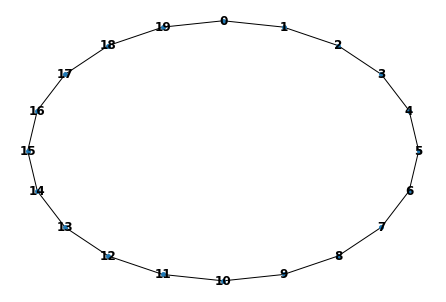

In [30]:
n = 20
ring_latt = geometric_network('ring_lattice', size = n, banded = False)
ring_latt.display()

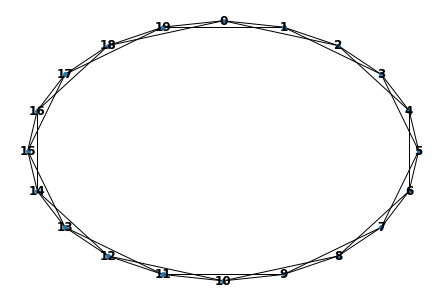

In [31]:
n = 20
banded_ring_latt = geometric_network('ring_lattice', size = n, banded = True, band_length = 2)
banded_ring_latt.display()

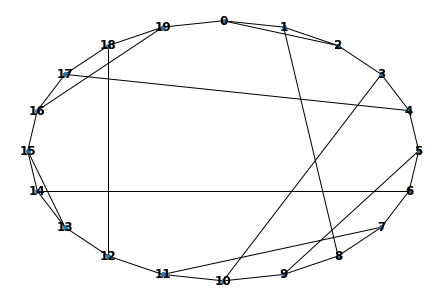

In [32]:
n = 20
d2 = 1
ring_latt_k_regular =  geometric_network('ring_lattice', size = n, banded = False)#, band_length = 5)
ring_latt_k_regular.add_noise_to_geometric('k_regular', d2)
ring_latt_k_regular.display()

# 2) Sample Excitation Simulation
   ### Use .run_exciation() method for the desired network. Output is the first activation times

In [33]:
p = 0.65 # cascade spreading probablioty
T = 100 # number of iterations
seed = int(n/2) # node that the spread starts
threshold = 0.1 # resistence of the node to it's neighbors' excitation level
Trials = 2 # number of trials

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean o

CPU times: user 770 ms, sys: 46.3 ms, total: 816 ms
Wall time: 959 ms


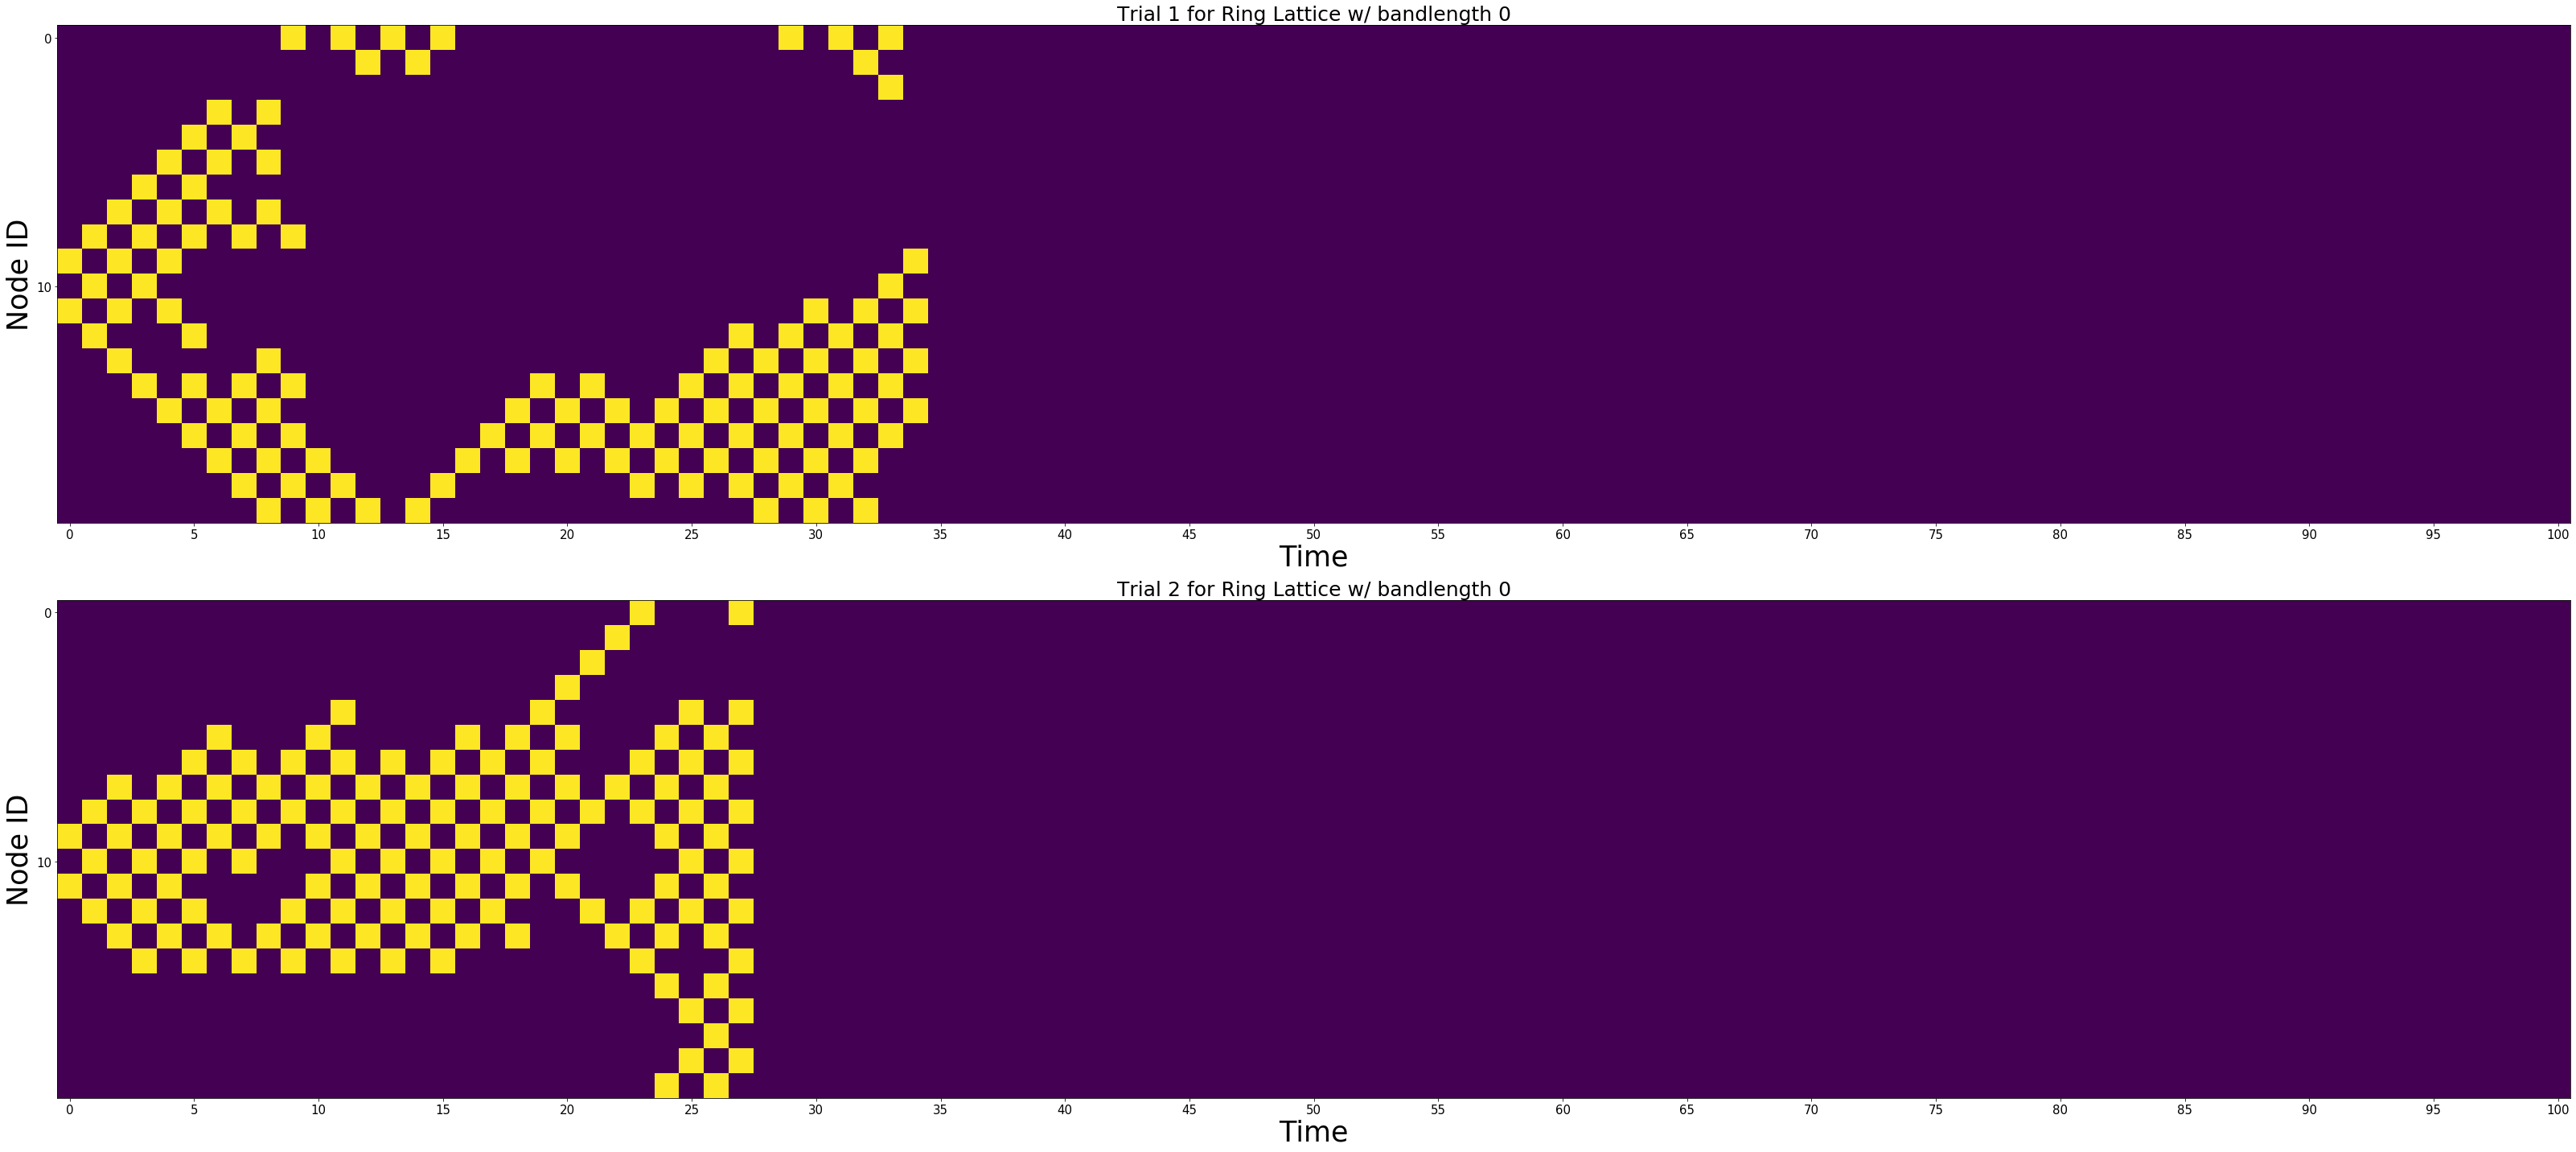

In [34]:
%%time
fig, ax = plt.subplots(2,1, figsize= (50,20))
first_excitation_times1,contagion_size1 = ring_latt.run_excitation(Trials, p, T, seed, threshold, ax = ax)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


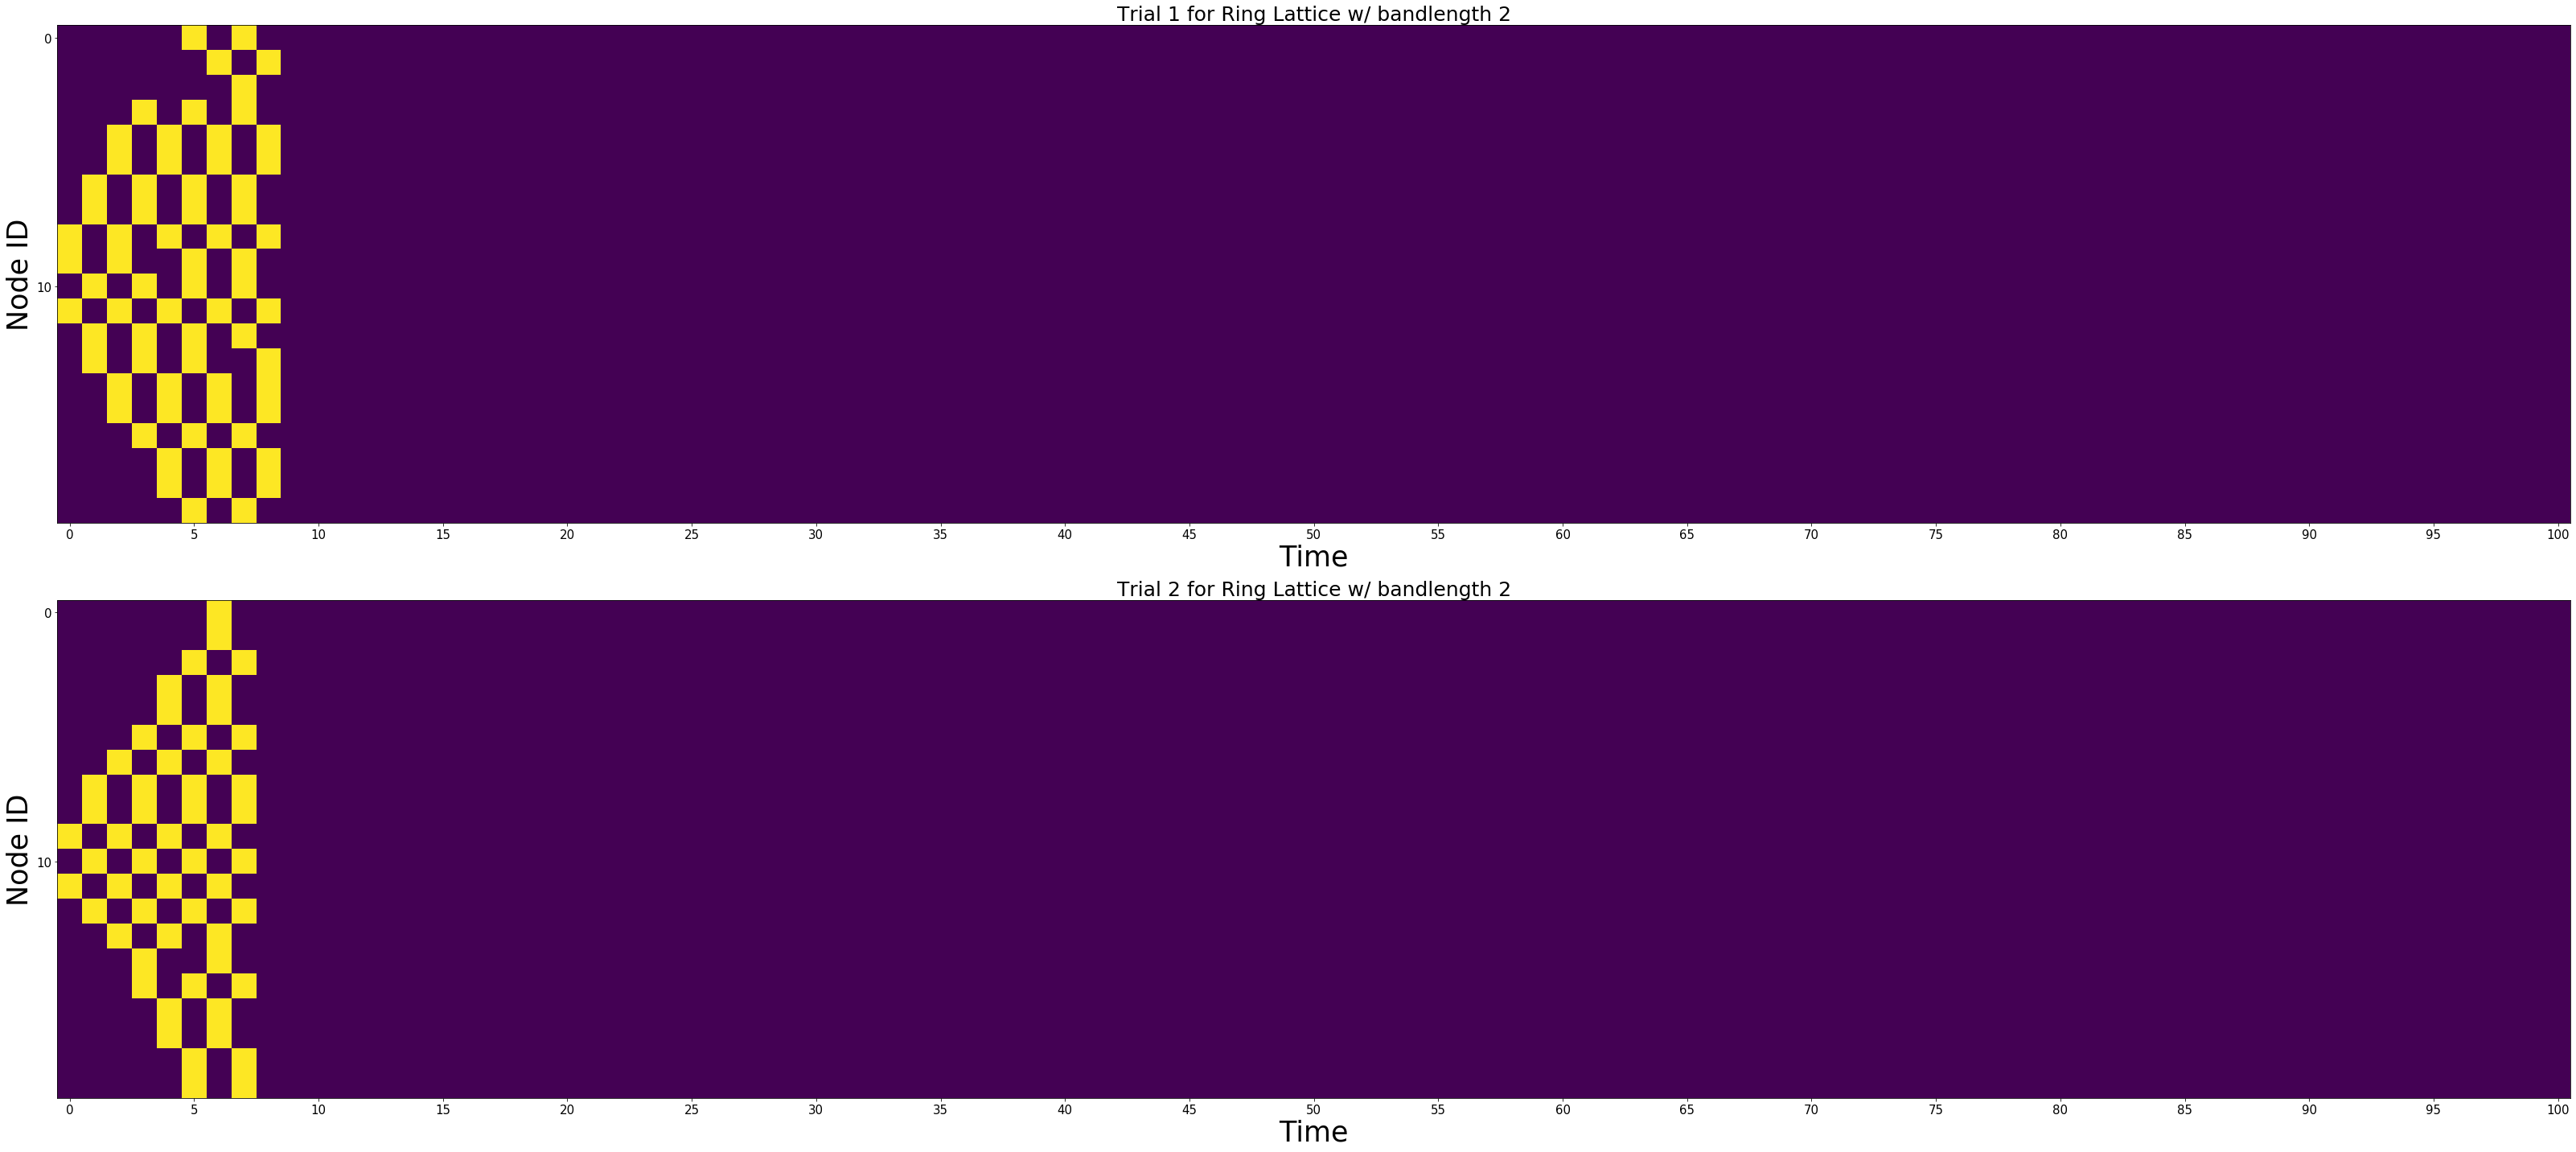

In [35]:
fig,ax = plt.subplots(2,1, figsize= (50,20))
first_excitation_times2,contagion_size2 = banded_ring_latt.run_excitation(Trials, p, T, seed, threshold, ax = ax)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean o

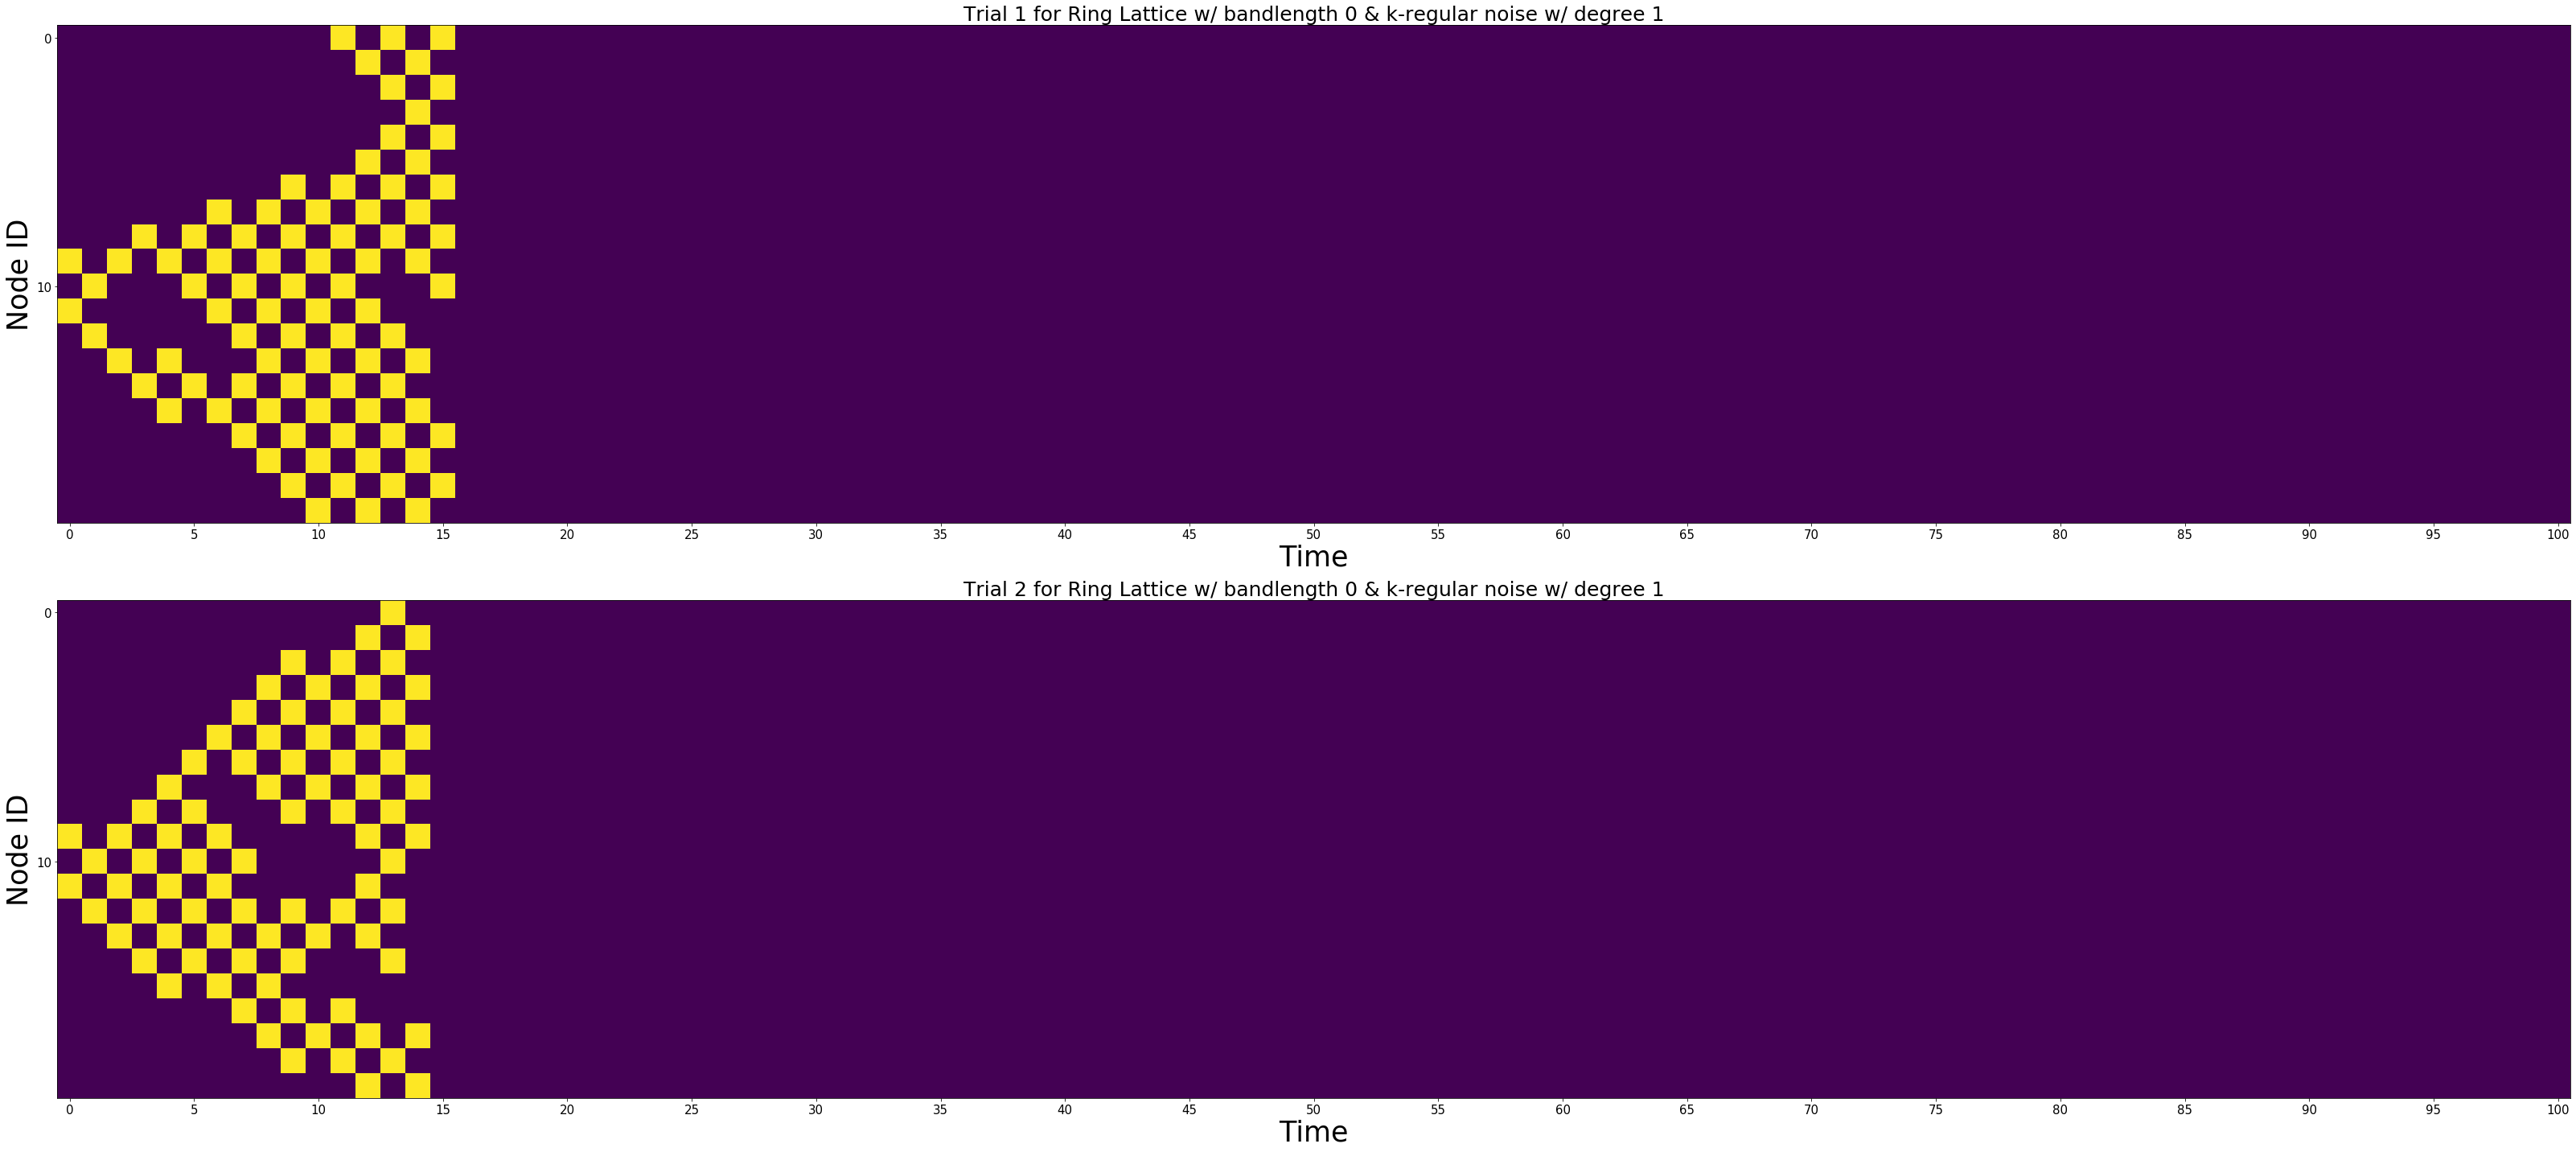

In [36]:
fig,ax = plt.subplots(2,1, figsize = (50,20))
first_excitation_times4,contagion_size4 = ring_latt_k_regular.run_excitation(2, p, T, seed, threshold, ax = ax)

# 3) Observing the first activation times
### input the output of the run_excitation to the .spy_first_activation() method

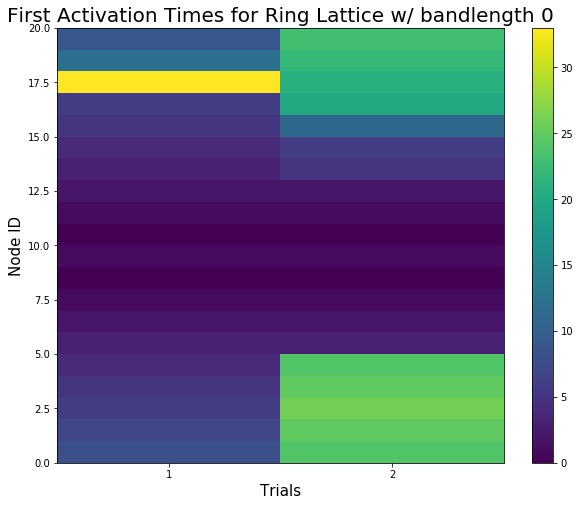

In [37]:
ring_latt.spy_first_activation(first_excitation_times1)

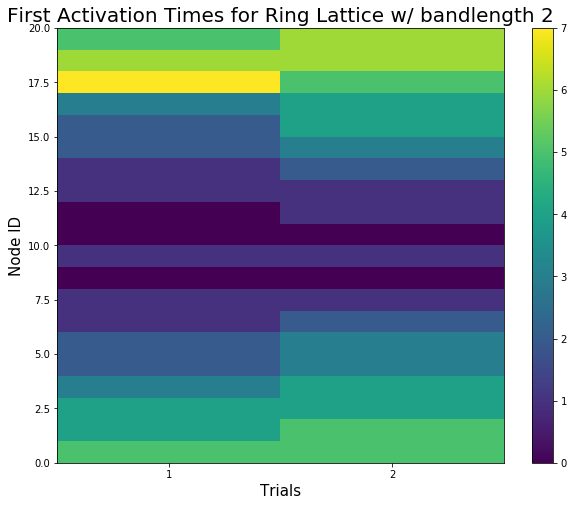

In [38]:
banded_ring_latt.spy_first_activation(first_excitation_times2)

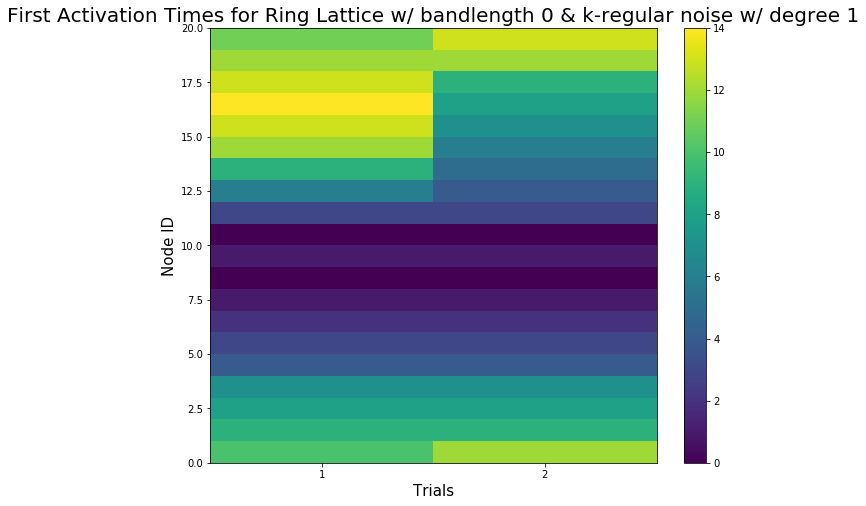

In [39]:
ring_latt_k_regular.spy_first_activation(first_excitation_times4)

# 4) You can run everything so far with make_distance_matrix
### it's gonna run the simulation starting from node i and finding first activation of node j, taking averages over the number of trials and put everything into a distance matrix

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


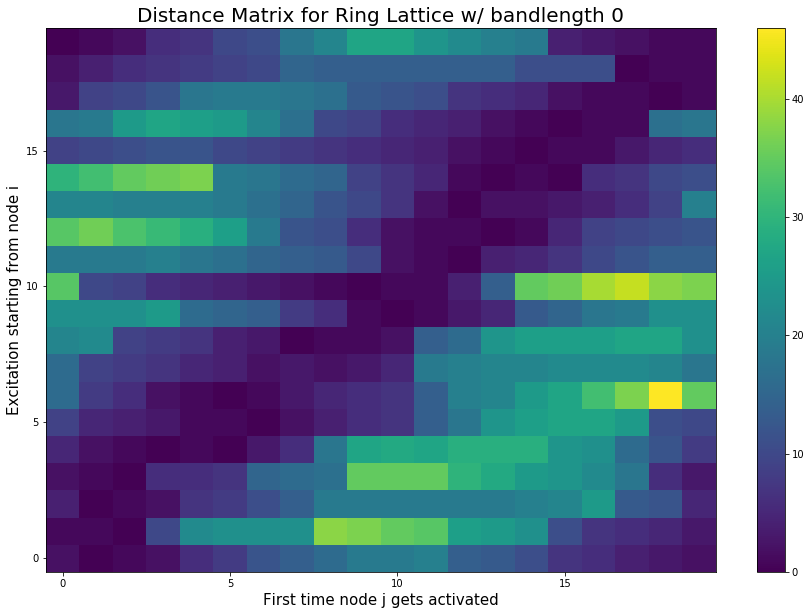

In [40]:
D1,Q1 = ring_latt.make_distance_matrix(p, T, threshold, Trials, spy_distance = True)

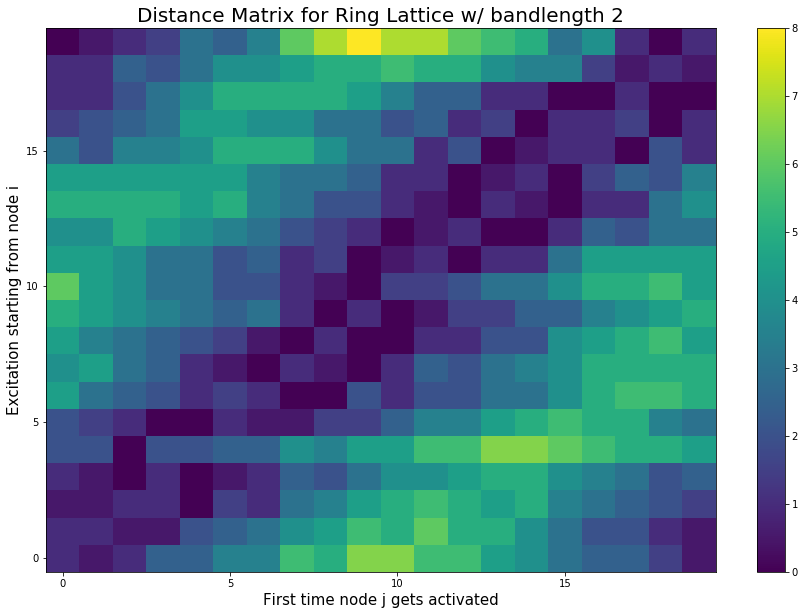

In [41]:
D2,Q2 = banded_ring_latt.make_distance_matrix(p, T, threshold, Trials, spy_distance = True)

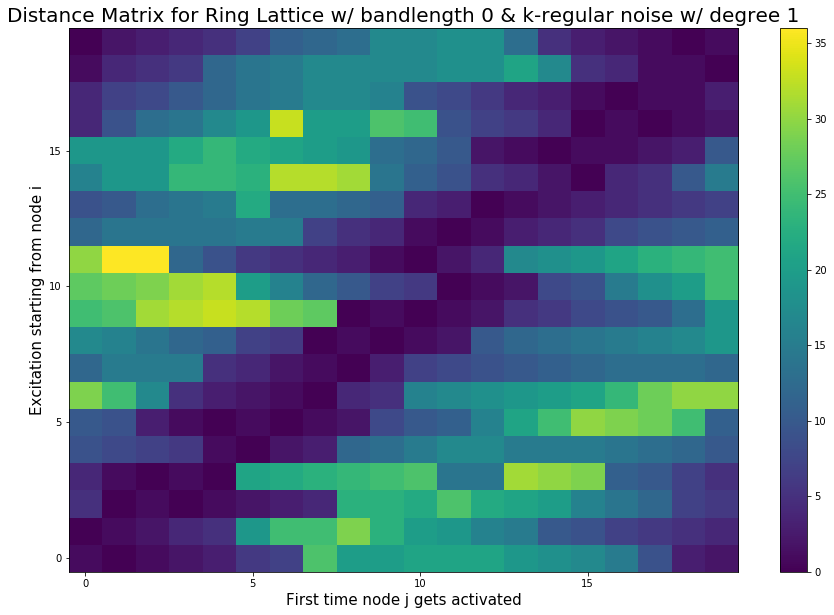

In [42]:
D3,Q3 = ring_latt_k_regular.make_distance_matrix(p, T, threshold, Trials, spy_distance = True)

In [95]:
def display_comm_sizes(Q, labels):
    fig,ax = plt.subplots(1,1, figsize =(20,10))
    for i in range(len(Q)):
        Q_mean = np.mean(Q[i], axis = 0)
        ax.plot(Q_mean[:int(np.max(np.nonzero(Q)[2])+10)], 
                label = '%s'%labels[i], marker = 'v')
        
        X = np.linspace(0,int(np.max(np.nonzero(Q)[2])+9),int(np.max(np.nonzero(Q)[2])+10))
        ax.fill_between(X, 
                        np.max(Q[i], axis = 0)[:int(np.max(np.nonzero(Q)[2])+10)], 
                        np.min(Q[i], axis = 0)[:int(np.max(np.nonzero(Q)[2])+10)], 
                        alpha = 0.2)
    ax.set_title('Size of the Active Nodes', fontsize = 25)
    ax.set_xlabel('Time', fontsize = 20)
    ax.set_ylabel('Number of Nodes', fontsize = 20)
    ax.legend(fontsize = 'x-large')

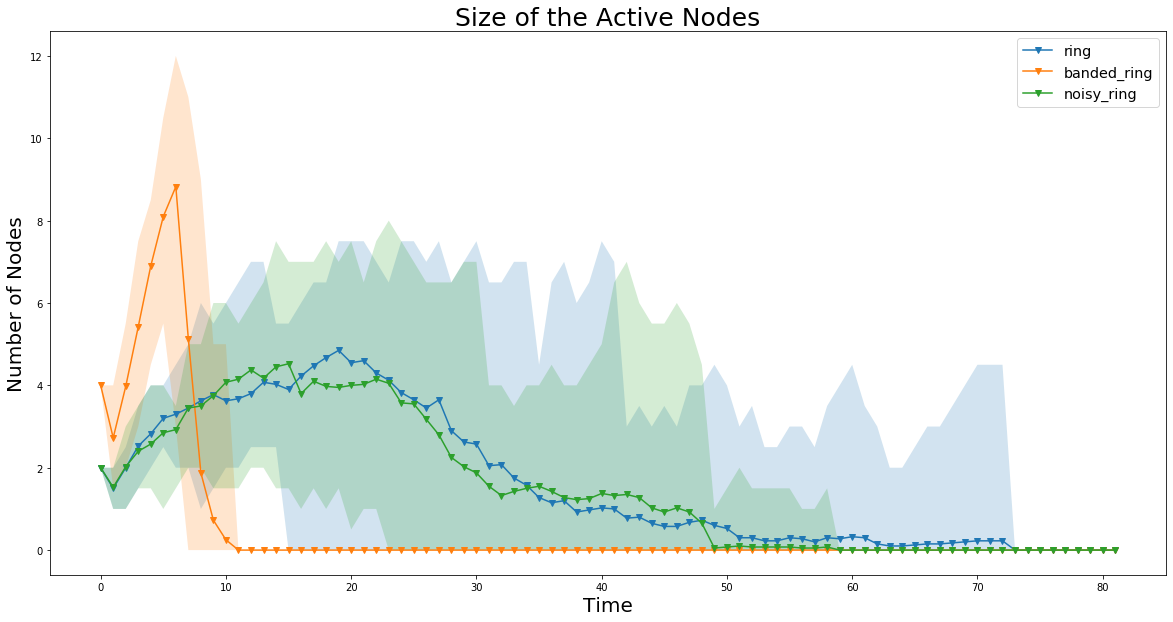

In [96]:
labels = ['ring', 'banded_ring', 'noisy_ring']
Q = [Q1,Q2,Q3]
display_comm_sizes(Q,labels)

# 5) You can look at the persistence diagrams of the above distance matrices
### Then compute the lifetime difference between largest two 1d-voids

Deprecated parameter. It has been replaced by max_intervals


([(1, (0.03278688524590164, 0.19672131147540983)),
  (0, (0.0, inf)),
  (0, (0.0, 0.03278688524590164)),
  (0, (0.0, 0.01639344262295082)),
  (0, (0.0, 0.01639344262295082)),
  (0, (0.0, 0.01639344262295082)),
  (0, (0.0, 0.01639344262295082)),
  (0, (0.0, 0.01639344262295082)),
  (0, (0.0, 0.01639344262295082)),
  (0, (0.0, 0.01639344262295082))],
 0.16393442622950818)

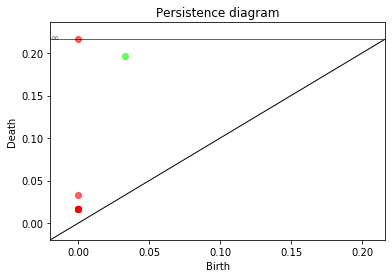

In [18]:
pers1 = ring_latt.compute_persistence(D1, spy = True)
delta1 = ring_latt.one_d_Delta(pers1)
pers1, delta1

Deprecated parameter. It has been replaced by max_intervals


<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

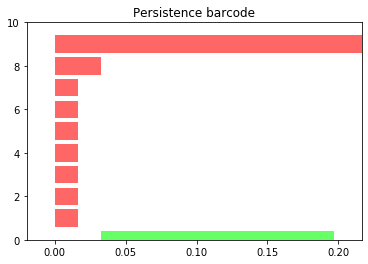

In [19]:
gudhi.plot_persistence_barcode(pers1)

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

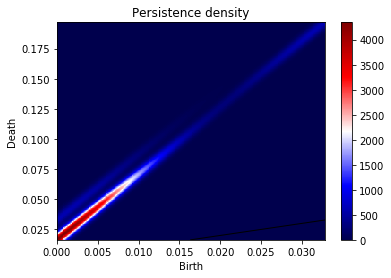

In [20]:
gudhi.plot_persistence_density(pers1, cmap = 'seismic', legend = True, max_intervals = 0)

Deprecated parameter. It has been replaced by max_intervals


([(1, (0.07142857142857142, 0.5)),
  (1, (0.0, 0.07142857142857142)),
  (0, (0.0, inf)),
  (0, (0.0, 0.07142857142857142)),
  (0, (0.0, 0.07142857142857142))],
 0.3571428571428572)

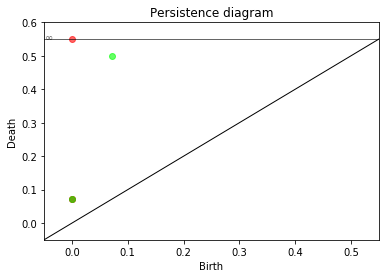

In [21]:
pers2 = banded_ring_latt.compute_persistence(D2, spy = True)
delta2 = banded_ring_latt.one_d_Delta(pers2)
pers2, delta2

Deprecated parameter. It has been replaced by max_intervals


<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

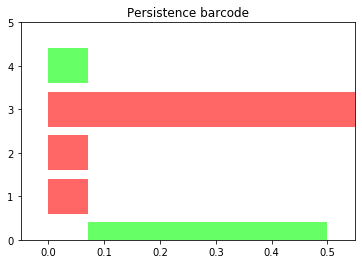

In [23]:
gudhi.plot_persistence_barcode(pers2)

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/kde.py:581: RuntimeWarning: invalid value encountered in sqrt
  self._norm_factor = sqrt(linalg.det(2*pi*self.covariance))


LinAlgError: 2-th leading minor of the array is not positive definite

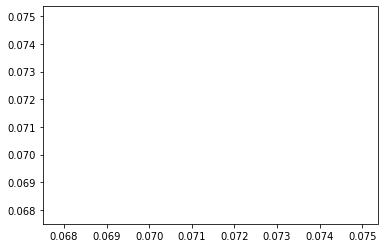

In [25]:
gudhi.plot_persistence_density(pers2, cmap = 'seismic', legend = True, max_intervals = 0)

Deprecated parameter. It has been replaced by max_intervals


([(1, (0.041666666666666664, 0.2708333333333333)),
  (0, (0.0, inf)),
  (0, (0.0, 0.041666666666666664)),
  (0, (0.0, 0.041666666666666664)),
  (0, (0.0, 0.020833333333333332)),
  (0, (0.0, 0.020833333333333332)),
  (0, (0.0, 0.020833333333333332)),
  (0, (0.0, 0.020833333333333332))],
 0.22916666666666666)

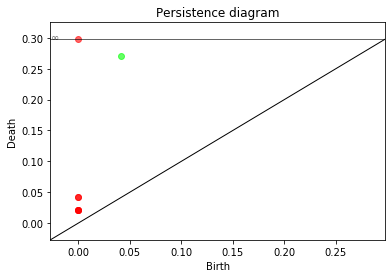

In [26]:
pers3 = ring_latt_k_regular.compute_persistence(D3, spy = True)
delta3 = ring_latt_k_regular.one_d_Delta(pers3)
pers3, delta3

Deprecated parameter. It has been replaced by max_intervals


<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

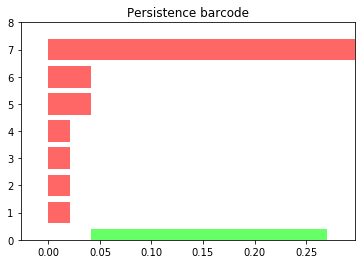

In [27]:
gudhi.plot_persistence_barcode(pers3)

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

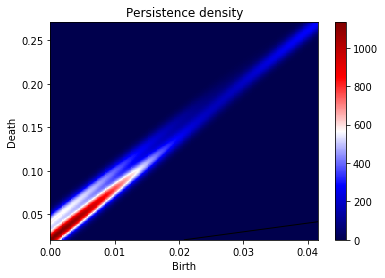

In [28]:
gudhi.plot_persistence_density(pers3, cmap ='seismic', legend = True, max_intervals = 0)

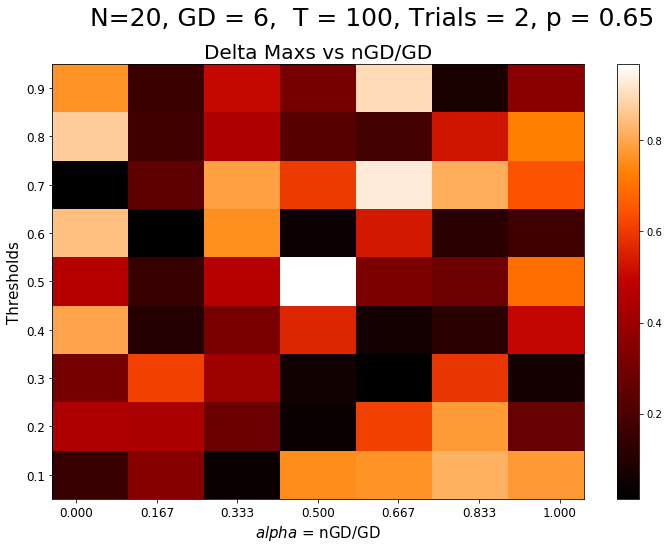

In [48]:
bands =3
d2s = [1,2,3,4,5,6]
thresholds = np.linspace(0.1,0.9,9)
fig,ax = plt.subplots(1,1,figsize = (12,8))
im = ax.imshow(dm, cmap = 'gist_heat', extent = [-.05,1.05,0.05,0.95])
fig.suptitle('N=%d, GD = %d,  T = %d, Trials = %d, p = %.2f'%(n,2*bands,T, Trials, p),fontsize = 25)
ax.set_title('Delta Maxs vs nGD/GD', fontsize = 20)
ax.set_xticks(np.array([0]+d2s)/(2*bands))
ax.set_yticks(thresholds)
ax.set_xlabel('$alpha$ = nGD/GD', fontsize = 15 )
ax.set_ylabel('Thresholds', fontsize = 15)
ax.tick_params(axis = 'both', labelsize = 12)
fig.colorbar(im)

In [44]:
dm = np.array([random.uniform(0,1) for i in range(63)]).reshape(9,7)